# 1.import Dependencise and data


> refrense (https://www.youtube.com/watch?v=AALBGpLbj6Q)

In [1]:
#!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [2]:
#!pip list

In [3]:
#bringing in tensorflow 
import tensorflow as tf 
gpus = tf.config.experimental.list_logical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu ,True)

In [4]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
!mkdir ./logs/

In [5]:
for gpu in gpus:
    print(gpu)

In [6]:
#brining in tensorflow datasets for tf_flower
import tensorflow_datasets as tfds
#brining in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [7]:
#use the tensorflow datasets api to bring in the data source
#ds = tfds.load('fashion_mnist', split='train')

In [8]:
ds = tfds.load('tf_flowers', split='train')

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [9]:
ds.as_numpy_iterator().next().keys()
ds.as_numpy_iterator().next()['image']
ds.as_numpy_iterator().next()['label']

2

# 2.Visualization data and build dataset

In [10]:
#do some data transformation
import numpy as np

In [11]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [12]:
# Getting data out of the pipeline
dataiterator.next()['image']

array([[[ 93, 122,  30],
        [ 90, 118,  31],
        [ 88, 118,  28],
        ...,
        [247,  77,  78],
        [253,  87,  87],
        [255,  76,  75]],

       [[ 98, 125,  30],
        [ 95, 124,  32],
        [ 96, 125,  32],
        ...,
        [247,  81,  83],
        [250,  86,  84],
        [252,  71,  64]],

       [[ 98, 126,  26],
        [101, 128,  31],
        [106, 132,  33],
        ...,
        [254,  81,  85],
        [254,  79,  76],
        [252,  55,  47]],

       ...,

       [[ 35,  51,   6],
        [ 21,  49,   0],
        [ 30,  57,   6],
        ...,
        [224, 239,  78],
        [192, 208,  50],
        [ 88,  54,  53]],

       [[ 65,  73,  32],
        [ 20,  46,   0],
        [ 22,  48,   0],
        ...,
        [230, 236,  74],
        [230, 246,  62],
        [ 88,  57,  36]],

       [[ 95,  97,  60],
        [ 15,  41,   0],
        [ 23,  51,   3],
        ...,
        [210, 224,  40],
        [210, 241,  23],
        [ 93,  87,  11]]

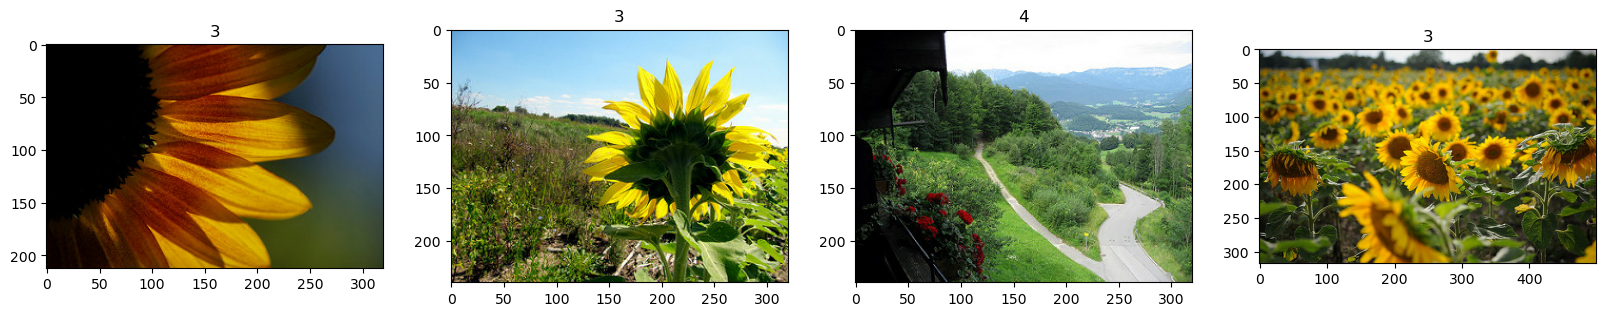

In [13]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [14]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [15]:
# Reload the dataset 
ds = tfds.load('tf_flowers', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
#ds = ds.batch(128)
ds = ds.batch(64)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [16]:
#ds.as_numpy_iterator().next().shape

# Start Tensorboard

In [17]:
# Download Ngrok to tunnel the tensorboard port to an external port
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
import os
import multiprocessing


pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir ./logs/ --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]

--2023-03-09 20:28:15--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  6.54MB/s    in 2.0s    

2023-03-09 20:28:18 (6.54 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


# Get the url to access tensorboad

> Note: This block of code might throw an error while running all blocks at time. So run blocks one by one till the block below.

In [18]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://5009-35-194-133-193.ngrok.io


# 3.build neural network

> 3.1 import modelling components

In [19]:
#bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
#bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU , Dropout,UpSampling2D


> 3.2 build generator

In [20]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model


generator = build_generator()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [21]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 424ms/step


1/1 [==============================] - 0s 105ms/step


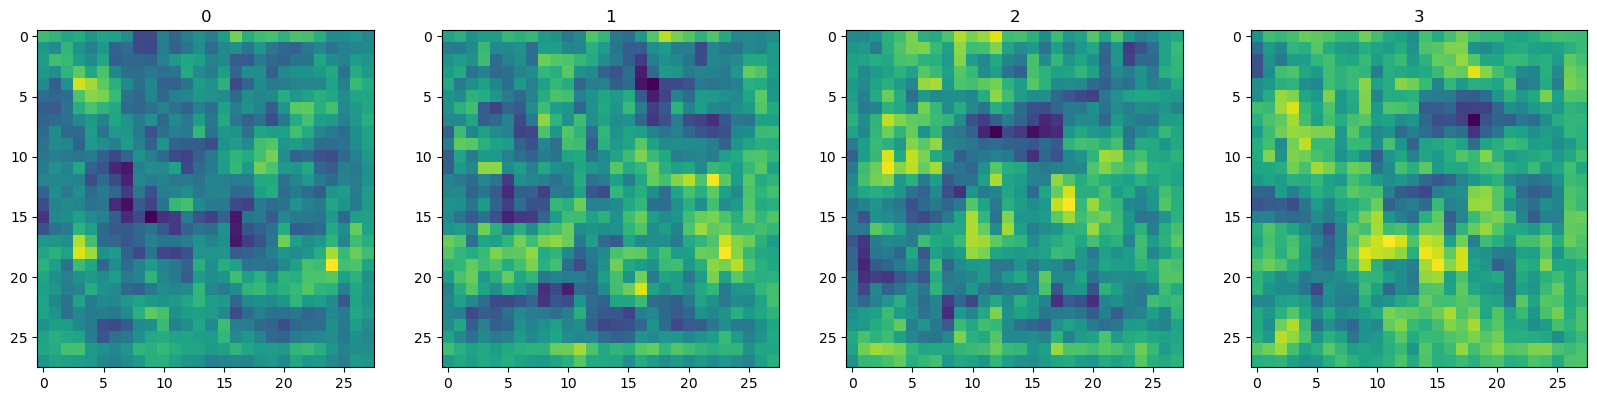

In [22]:
# Generate new flower image
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

In [23]:
img.shape

(28, 28, 1)

> 3.3 build discriminator

In [24]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [25]:
img = img[0]

In [26]:
img.shape

(28, 1)

In [27]:
discriminator.predict(img)

ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py", line 251, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "conv2d_5" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
      • training=False
      • mask=None


# 4.construct training loop

> 4.1 setup losses and optimizers

In [ ]:
#Adam id going to be the optimizer for both 
from tensorflow.keras.optimizers import Adam
#binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

> 4.2 build subclassed model

In [ ]:
#importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [ ]:
#tf.random.normal((6,128,1))
tf.ones_like(tf.random.normal((6,128)))

In [ ]:
class FlowerGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}
        
       
                                       
    


In [ ]:
#create instance of subclassed model 
flower_GAN = FlowerGAN(generator, discriminator)

In [ ]:
#compile the model 
flower_GAN.compile(g_opt,d_opt,g_loss,d_loss)

# 4.3 build callback

> 4.3 train

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [ ]:
#ds.as_numpy_iterator().next().shape

In [ ]:
#recommed 2000 epochs
hist = flower_GAN.fit(ds, epochs=20, callbacks=[ModelMonitor()])

# 4.4 review performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label = 'd_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()


# 5. Test Out the Generator

> 5.1 Generate Images

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')



NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.11.2 at http://0.0.0.0:6006/ (Press CTRL+C to quit)
